# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°1: Puntos de colocacion

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm

In [2]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [3]:
pressure_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:31:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'p': array([[0.00000000e+00, 1.62864847e-05, 1.31113620e-05, ...,
         1.05833522e+00, 1.66906380e+00, 3.40199098e+00]])}

In [4]:
velocity_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:33:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'u': array([[0.        , 0.        , 0.        , ..., 0.65946941, 0.49345089,
         0.17337734]]),
 'v': array([[ 0.        ,  0.        ,  0.        , ..., -0.03262434,
         -0.06381343, -0.15660411]]),
 'w': array([[0., 0., 0., ..., 0., 0., 0.]])}

### 1. Xpde y Xbc

In [5]:
# n_pde debe ser = n^2 para grilla regular
n_pde = 1024
n_bc= 100

x_lb = 0
x_ub = 1
y_lb = 0
y_ub = 1

#### Grilla regular

In [6]:
def get_xy_pde_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(np.sqrt(n) + 1)
    y_step = (y_bounds[1]-y_bounds[0])/(np.sqrt(n) + 1)
    x = np.arange(x_bounds[0] + x_step, x_bounds[1], x_step)
    y = np.arange(y_bounds[0]  + y_step, y_bounds[1], y_step)
    return np.array([[x_i, y_i] for x_i in x for y_i in y])

xy_pde_mesh = get_xy_pde_mesh([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [7]:
def get_xy_bc_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(n / 4)
    y_step = (y_bounds[1]-y_bounds[0])/(n / 4)
    l1 = np.array([[x_i, y_bounds[0]] for x_i in np.arange(x_bounds[0], x_bounds[1], x_step)])
    l2 = np.array([[x_bounds[1], y_i] for y_i in np.arange(y_bounds[0], y_bounds[1], y_step)])
    l3 = np.array([[x_i, y_bounds[1]] for x_i in np.arange(x_bounds[1], x_bounds[0], -x_step)])
    l4 = np.array([[x_bounds[0], y_i] for y_i in np.arange(y_bounds[1], y_bounds[0], -y_step)])
    return np.concatenate([l1,l2,l3,l4], axis=0)

xy_bc_mesh = get_xy_bc_mesh([x_lb, x_ub], [y_lb, y_ub], n_bc)

#### Muestreo aleatorio

In [8]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [9]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)

### 2. Graficar puntos de colocación

#### Grilla regular

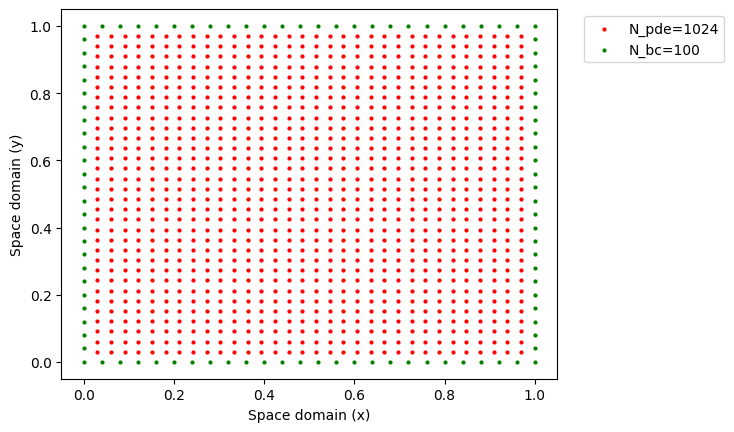

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_mesh[:,0], xy_pde_mesh[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_mesh[:,0], xy_bc_mesh[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### Muestreo aleatorio

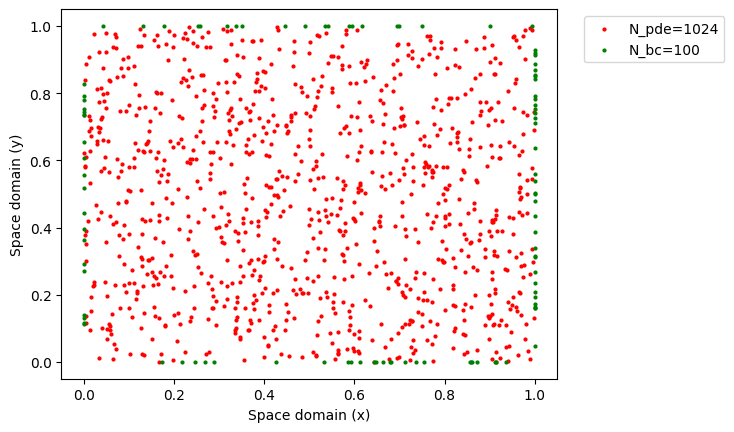

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_random[:,0], xy_pde_random[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_random[:,0], xy_bc_random[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### 3. Datos rotulados

In [12]:
n_data = 10

In [13]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, n_data)

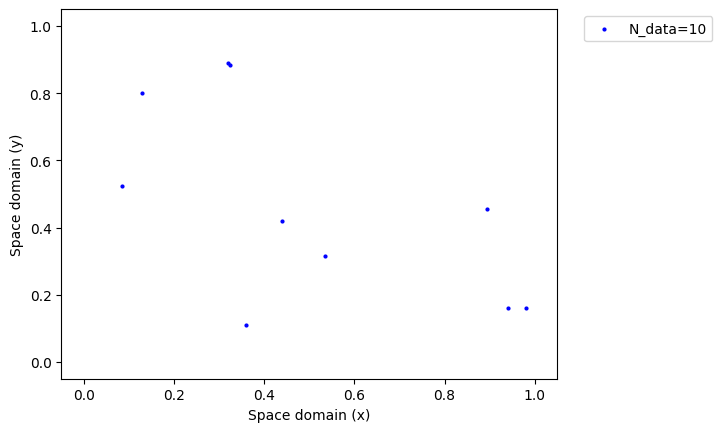

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_data_random[:,0], xy_data_random[:,1], s=4, c='b', label=f'N_data={len(xy_data_random)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Este dataset de datos rotulados contiene no solamente los valores de input (x e y) del modelo sino también los valores de las etiquetas/salidas (p, u, v), por lo que constituye un caso de entrenamiento supervisado. En cambio, los datasets de puntos de colocación contienen solamente los valores de input (x e y) del modelo, por lo que se asemejaría más a un problema no supervisado, pero en realidad lo convertimos en "supervisado" a traves del uso de las EDP.

Como la estructura del dataset de datos rotulados y la de los datasets de puntos de colocación son diferentes, no podremos concatenarlos y seleccionar aleatoriamente batch que incluyan puntos de ambos al mismo tiempo. En su lugar, tendremos que entrenar el modelo de a pasos.

### 4. Para pensar

El sub-conjunto de los puntos de colocación xy_pde no debería contener puntos sobre la frontera del dominio, ya que la definición de la PDE se hace sobre el conjunto abierto del dominio (sin incluir el borde).